# Plot Something

In [1]:
%matplotlib inline
import cosima_cookbook as cc
from dask.distributed import Client
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import cmocean as cm
from cosima_cookbook import explore

In [2]:
db = '/g/data/x77/amh157/anu-tub/diagnostics/anu-tub.db'
session=cc.database.create_session(db)
experiment='anu-tub-n3'

In [3]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 125.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39551,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.20 GiB
Comm: tcp://127.0.0.1:42447,Total threads: 4
Dashboard: /proxy/45937/status,Memory: 17.89 GiB
Nanny: tcp://127.0.0.1:41235,


# Spinup Diagnostics


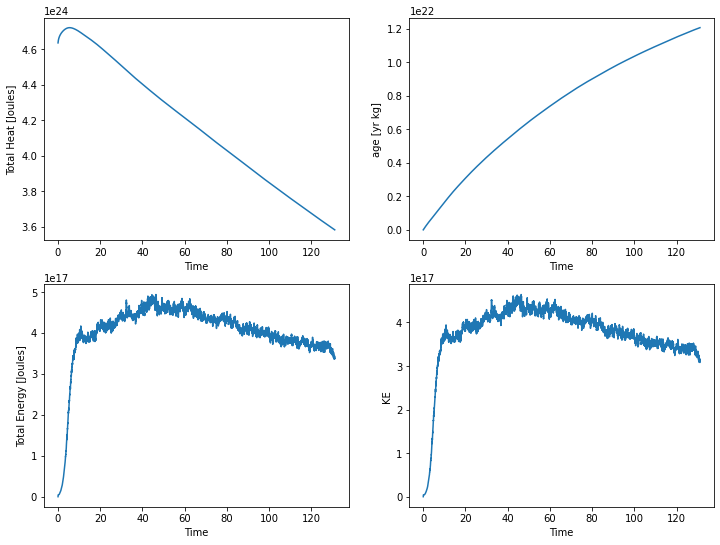

In [5]:
fig, ax = plt.subplots(2,2,figsize=(12,9))

variable = 'Heat'
darray = cc.querying.getvar(experiment, variable, session,ncfile='ocean.stats.nc',decode_times=False)
darray.coords['Time'] = darray.coords['Time']/365
darray.plot(ax=ax[0,0])
                                               
variable = 'En'
darray = cc.querying.getvar(experiment, variable, session,ncfile='ocean.stats.nc',decode_times=False)
darray.coords['Time'] = darray.coords['Time']/365
darray.plot(ax=ax[1,0])

variable = 'age'
darray = cc.querying.getvar(experiment, variable, session,ncfile='ocean.stats.nc',decode_times=False)
darray.coords['Time'] = darray.coords['Time']/365
darray.plot(ax=ax[0,1])
                                               
variable = 'KE'
darray = cc.querying.getvar(experiment, variable, session,ncfile='ocean.stats.nc',decode_times=False)
darray.coords['Time'] = darray.coords['Time']/365
darray.sum('Layer').plot(ax=ax[1,1])

# Extra Spinup Diagnostics

Text(0.5, 1.0, 'Overturning Circulation (Sv)')

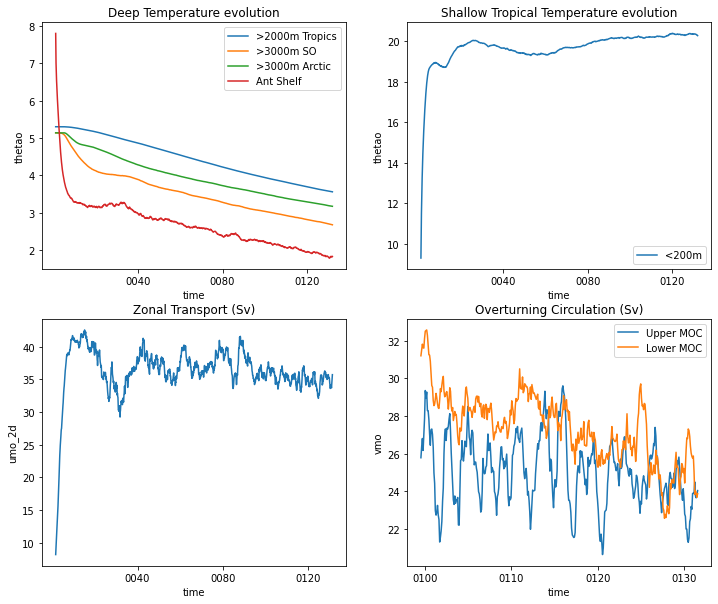

In [73]:
fig, ax = plt.subplots(2,2,figsize=(12,10))

# Timeseries of deep tropical temp
darray = cc.querying.getvar(experiment, 'thetao', session)

deep_temp = darray.sel(z_l=slice(2000,4000)).mean('z_l').sel(yh=slice(-30,30)).mean('yh').sel(xh=slice(10,30)).mean('xh')
deep_temp.plot(ax=ax[0,0],label='>2000m Tropics')
deep_temp = darray.sel(z_l=slice(3000,4000)).mean('z_l').sel(yh=slice(-62,-50)).mean('yh').mean('xh')
deep_temp.plot(ax=ax[0,0],label='>3000m SO')
deep_temp = darray.sel(z_l=slice(3000,4000)).mean('z_l').sel(yh=slice(50,62)).mean('yh').mean('xh')
deep_temp.plot(ax=ax[0,0],label='>3000m Arctic')
shelf_temp = darray.mean('z_l').sel(yh=slice(-70,-65)).mean('yh').mean('xh')
shelf_temp.plot(ax=ax[0,0],label='Ant Shelf')
ax[0,0].legend()
ax[0,0].set_title('Deep Temperature evolution')

shallow_temp = darray.sel(z_l=slice(0,200)).mean('z_l').sel(yh=slice(-30,30)).mean('yh').sel(xh=slice(10,30)).mean('xh')
shallow_temp.plot(ax=ax[0,1],label='<200m')
ax[0,1].legend()
ax[0,1].set_title('Shallow Tropical Temperature evolution')

darray = cc.querying.getvar(experiment, 'umo_2d', session, frequency='1 monthly')
dp_trans = darray.isel(xq=0).sum('yh').rolling(time=12,center=True).mean().dropna('time').load()/1e9
dp_trans.plot(ax=ax[1,0],label='Zonal Transport')
ax[1,0].set_title('Zonal Transport (Sv)')

darray = cc.querying.getvar(experiment, 'vmo', session,start_time=start_time)
moc = darray.sum('xh').cumsum('rho2_l').sel(rho2_l=slice(1034,1038)).rolling(time=12,center=True).mean().dropna('time')/1e9
amoc = moc.max(['rho2_l','yq']).load()
gmoc = -moc.min(['rho2_l','yq']).load()
amoc.plot(ax=ax[1,1],label='Upper MOC')
gmoc.plot(ax=ax[1,1],label='Lower MOC')
ax[1,1].legend()
ax[1,1].set_title('Overturning Circulation (Sv)')


# Plotting some maps

In [4]:
def plot_mercator(ax,X0,Y0):
    X,Y = np.meshgrid(X0,Y0)
    X_alt = (X - 20)*np.cos(Y*np.pi/180) + 20
    
    ax.set_frame_on(False)
    ax.plot(X_alt[:,0],Y[:,0],'k')
    ax.plot(X_alt[:,-1],Y[:,-1],'k')
    ax.plot([X_alt[-1,0], X_alt[-1,-1]],[69.8, 69.8],'k')
    ax.plot([X_alt[0,0], X_alt[0,-1]],[-70, -70],'k')
    ax.set_xlabel('Longitude')
    
    ax.set_ylim(ymin=-70,ymax=70)
    plt.setp(ax,'xticks',[10, 20, 30])
    return X_alt, Y

In [5]:
start_time='01-01-100'

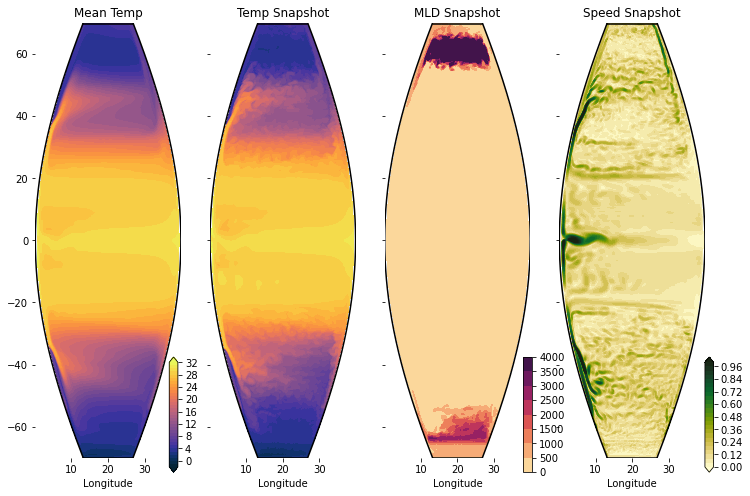

In [33]:
fig, ax = plt.subplots(1,4,figsize=(12,8))
vlev = np.linspace(-2,32,35)

#
darray = cc.querying.getvar(experiment, 'tos', session,start_time=start_time)
temp_surf = darray.mean('time').load()
X,Y = plot_mercator(ax[0],temp_surf.coords['xh'],temp_surf.coords['yh'])
p1=ax[0].contourf(X,Y,temp_surf,levels=vlev,extend='both',cmap=cm.cm.thermal)
ax[0].set_title('Mean Temp')


#
darray = cc.querying.getvar(experiment, 'tos', session,start_time=start_time)
temp_snap = darray.isel(time=-1).load()
X,Y = plot_mercator(ax[1],temp_snap.coords['xh'],temp_snap.coords['yh'])
p1=ax[1].contourf(X,Y,temp_snap,levels=vlev,extend='both',cmap=cm.cm.thermal)
ax[1].set_title('Temp Snapshot')
ax[1].set_yticklabels('')

cbax = plt.axes([0.28,0.1,0.01,0.2])
plt.colorbar(p1,cbax)

#
darray = cc.querying.getvar(experiment, 'mlotst', session,start_time=start_time)
mld_snap = darray.isel(time=-1).load()
X,Y = plot_mercator(ax[2],mld_snap.coords['xh'],mld_snap.coords['yh'])
p1=ax[2].contourf(X,Y,mld_snap,cmap=cm.cm.matter)
ax[2].set_title('MLD Snapshot')
ax[2].set_yticklabels('')


cbax = plt.axes([0.69,0.1,0.01,0.2])
plt.colorbar(p1,cbax)

#
slev = np.linspace(0,1,26)
darray = cc.querying.getvar(experiment, 'uo', session,start_time=start_time)
u_snap = darray.isel(time=-1).isel(z_l=0).load()
darray = cc.querying.getvar(experiment, 'vo', session,start_time=start_time)
v_snap = darray.isel(time=-1).isel(z_l=0).load()
speed = (u_snap.values[:,:-1]**2 + v_snap[:-1,:].values**2)**(0.5)
X,Y = plot_mercator(ax[3],temp_snap.coords['xh'],temp_snap.coords['yh'])
p1=ax[3].contourf(X,Y,speed,levels=slev,extend='both',cmap=cm.cm.speed)
ax[3].set_title('Speed Snapshot')
ax[3].set_yticklabels('')


cbax = plt.axes([0.9,0.1,0.01,0.2])
plt.colorbar(p1,cbax)


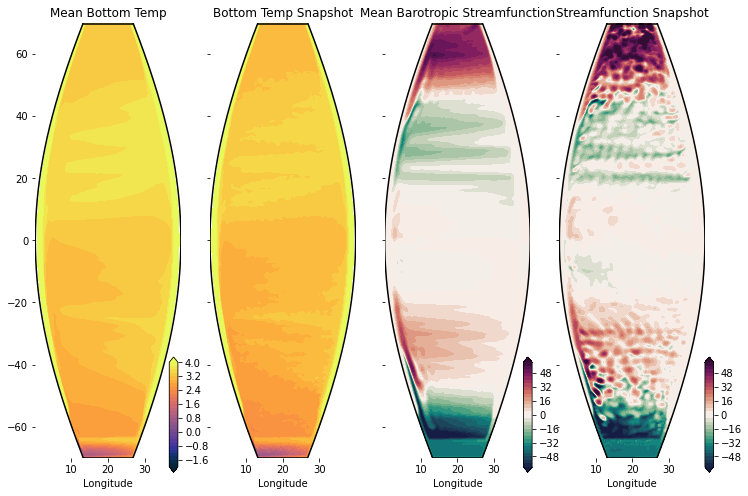

In [52]:
fig, ax = plt.subplots(1,4,figsize=(12,8))
vlev = np.linspace(-2,4,31)

#
darray = cc.querying.getvar(experiment, 'tob', session,start_time=start_time)
temp_surf = darray.mean('time').load()
X,Y = plot_mercator(ax[0],temp_surf.coords['xh'],temp_surf.coords['yh'])
p1=ax[0].contourf(X,Y,temp_surf,levels=vlev,extend='both',cmap=cm.cm.thermal)
ax[0].set_title('Mean Bottom Temp')


#
darray = cc.querying.getvar(experiment, 'tob', session,start_time=start_time)
temp_snap = darray.isel(time=-1).load()
X,Y = plot_mercator(ax[1],temp_snap.coords['xh'],temp_snap.coords['yh'])
p1=ax[1].contourf(X,Y,temp_snap,levels=vlev,extend='both',cmap=cm.cm.thermal)
ax[1].set_title('Bottom Temp Snapshot')
ax[1].set_yticklabels('')

cbax = plt.axes([0.28,0.1,0.01,0.2])
plt.colorbar(p1,cbax)

#
darray = cc.querying.getvar(experiment, 'umo_2d', session,start_time=start_time, frequency='1 monthly')
psi = darray.mean('time').cumsum('yh').load()
psi = (psi - psi.isel(xq=-1).isel(yh=-1))/1e9
X,Y = plot_mercator(ax[2],psi.coords['xq'],psi.coords['yh'])
p1=ax[2].contourf(X,Y,psi,cmap=cm.cm.curl,levels=np.linspace(-60,60,31),extend='both')
ax[2].set_title('Mean Barotropic Streamfunction')
ax[2].set_yticklabels('')


cbax = plt.axes([0.69,0.1,0.01,0.2])
plt.colorbar(p1,cbax)

#
darray = cc.querying.getvar(experiment, 'umo_2d', session,n=-1, frequency='1 daily')
psi = darray.isel(time=-1).cumsum('yh').load()
psi = (psi - psi.isel(xq=-1).isel(yh=-1))/1e9
X,Y = plot_mercator(ax[3],psi.coords['xq'],psi.coords['yh'])
p1=ax[3].contourf(X,Y,psi,cmap=cm.cm.curl,levels=np.linspace(-60,60,31),extend='both')
ax[3].set_title('Streamfunction Snapshot')
ax[3].set_yticklabels('')


cbax = plt.axes([0.9,0.1,0.01,0.2])
plt.colorbar(p1,cbax)

# A temperature profile
Note that I'm not averaging zero-thickness cells properly here.

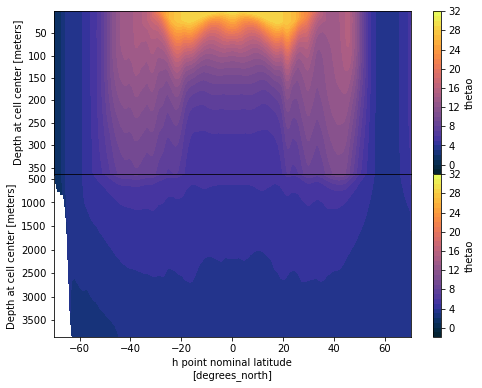

In [14]:
fig, ax = plt.subplots(2,1,figsize=(8,6))
plt.subplots_adjust(hspace=0)
vlev = np.linspace(-2,32,35)

darray = cc.querying.getvar(experiment, 'thetao', session,start_time=start_time)
temp_slice = darray.mean('time').sel(xh=slice(10,30)).mean('xh').load()


temp_slice.sel(z_l=slice(0,400)).plot.contourf(ax=ax[0],levels=vlev,yincrease=False,cmap=cm.cm.thermal)
temp_slice.sel(z_l=slice(400,4000)).plot.contourf(ax=ax[1],levels=vlev,yincrease=False,cmap=cm.cm.thermal)

# Overturning Circulation


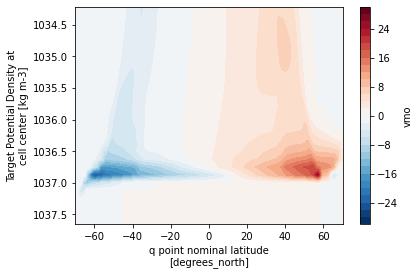

In [23]:
darray = cc.querying.getvar(experiment, 'vmo', session,start_time=start_time)
moc = darray.sum('xh').mean('time').cumsum('rho2_l')/1e9
moc.sel(rho2_l=slice(1034,1038)).plot.contourf(levels=np.linspace(-30,30,31),yincrease=False)